# Lab 3: Decision tree - Wine quality

In [8]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
import graphviz
import os

## 1. Chuẩn bị dữ liệu

Features shape: (4898, 11)
Targets shape: (4898, 1)
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9

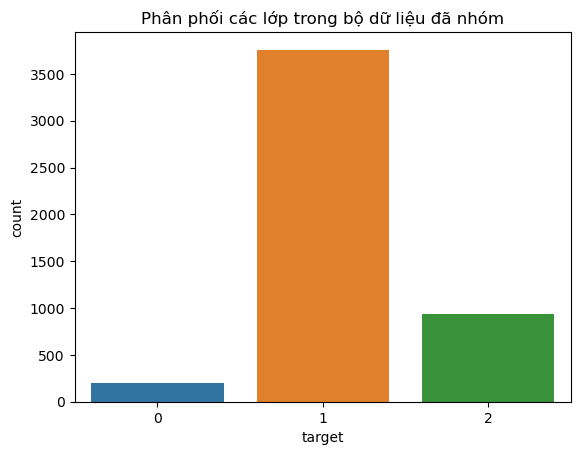


Tỷ lệ 40.0/60.0, Lần chia thứ 1:
Phân phối lớp trong tập huấn luyện:
1    0.767228
2    0.190914
0    0.041858
Name: target, dtype: float64
Phân phối lớp trong tập kiểm tra:
1    0.767268
2    0.191222
0    0.041511
Name: target, dtype: float64


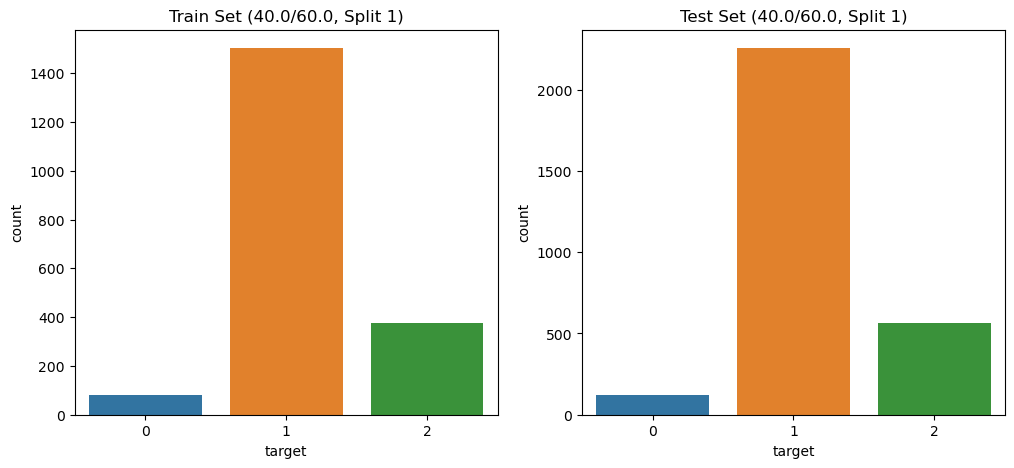


Tỷ lệ 60.0/40.0, Lần chia thứ 1:
Phân phối lớp trong tập huấn luyện:
1    0.767189
2    0.191287
0    0.041525
Name: target, dtype: float64
Phân phối lớp trong tập kiểm tra:
1    0.767347
2    0.190816
0    0.041837
Name: target, dtype: float64


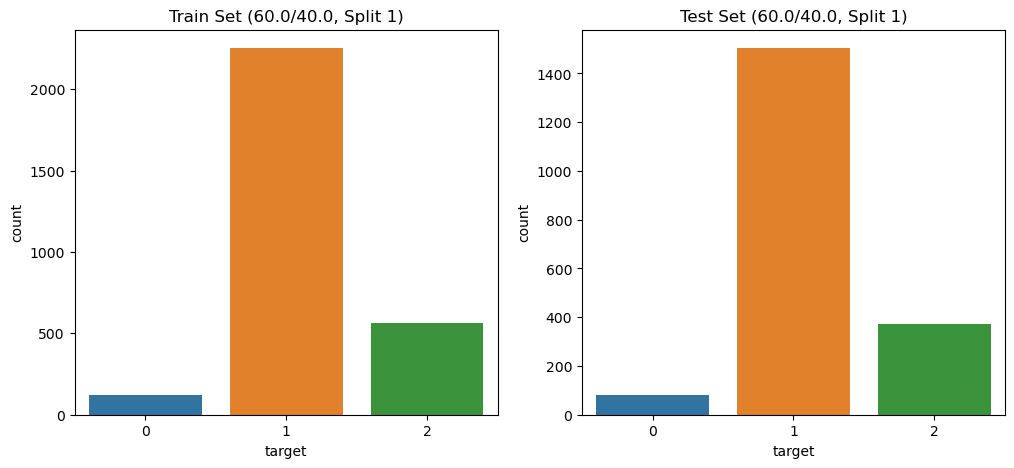


Tỷ lệ 80.0/20.0, Lần chia thứ 1:
Phân phối lớp trong tập huấn luyện:
1    0.767228
2    0.191169
0    0.041603
Name: target, dtype: float64
Phân phối lớp trong tập kiểm tra:
1    0.767347
2    0.190816
0    0.041837
Name: target, dtype: float64


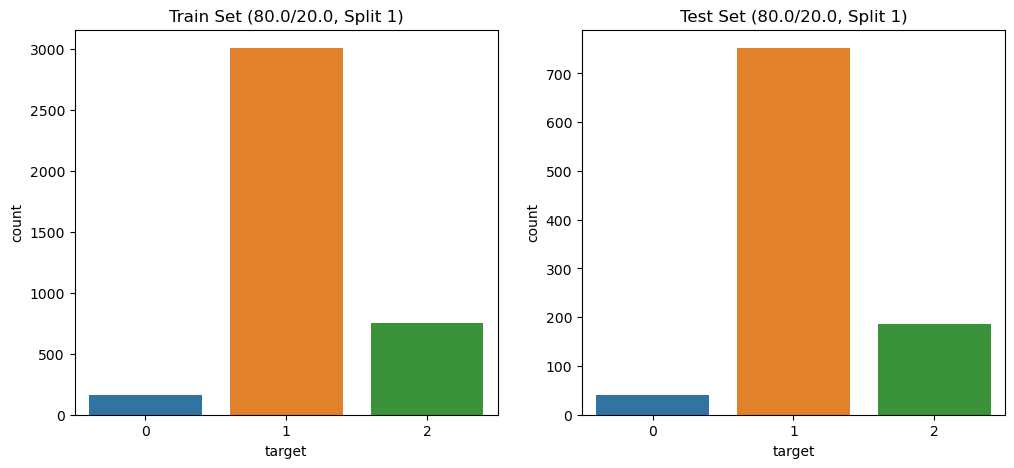


Tỷ lệ 90.0/10.0, Lần chia thứ 1:
Phân phối lớp trong tập huấn luyện:
1    0.767241
2    0.191016
0    0.041742
Name: target, dtype: float64
Phân phối lớp trong tập kiểm tra:
1    0.767347
2    0.191837
0    0.040816
Name: target, dtype: float64


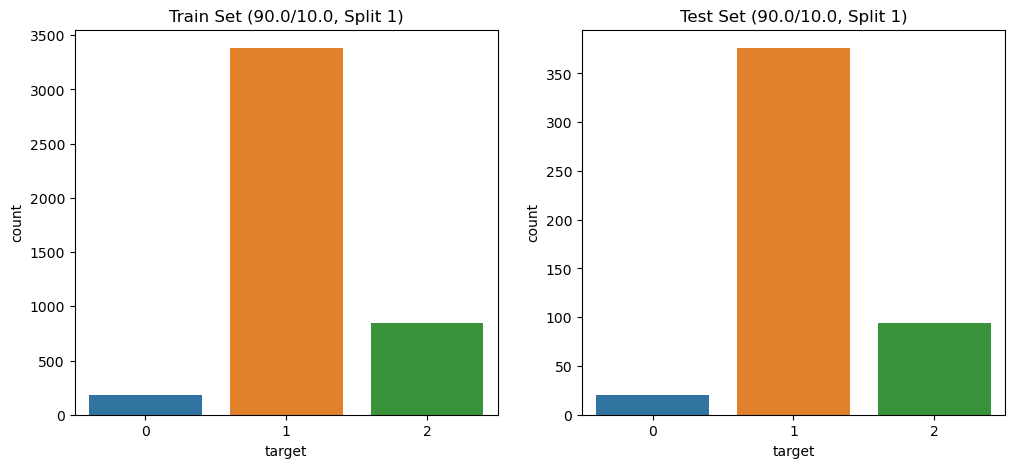

In [9]:
wine_quality = fetch_ucirepo(id=186) 

# Lấy các mẫu của winequality-white (4898 mẫu)
X = wine_quality.data.features[:4898]  
y = wine_quality.data.targets[:4898]
print(f"Features shape: {X.shape}")
print(f"Targets shape: {y.shape}")

# Chuyển đổi y từ DataFrame thành numpy ndarray và làm phẳng mảng y thành mảng 1 chiều
y = y.values.flatten() 

df = pd.DataFrame(X)
print(df.head())

def map_quality_class(target):
    if target <= 4:
        return 0  # Low quality
    elif target <= 6:
        return 1  # Standard quality
    else:
        return 2  # High quality

df['target'] = pd.Series(y).apply(map_quality_class)


sns.countplot(x='target', data=df)
plt.title("Phân phối các lớp trong bộ dữ liệu đã nhóm")
plt.show()

# Phân chia dữ liệu
X = df.drop(['target'], axis=1)
y = df['target']
proportions = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
splits = {}

for train_size, test_size in proportions:
    for i in range(1):  
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=i)
        for train_idx, test_idx in sss.split(X, y):
            splits[(train_size, test_size, i)] = (
                X.iloc[train_idx],
                X.iloc[test_idx],
                y.iloc[train_idx],
                y.iloc[test_idx]
            )
for (train_size, test_size, i), (X_train, X_test, y_train, y_test) in splits.items():
    print(f"\nTỷ lệ {train_size*100}/{test_size*100}, Lần chia thứ {i+1}:")
    print(f"Phân phối lớp trong tập huấn luyện:")
    print(y_train.value_counts(normalize=True))
    print(f"Phân phối lớp trong tập kiểm tra:")
    print(y_test.value_counts(normalize=True))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.countplot(x=y_train, ax=ax[0])
    ax[0].set_title(f"Train Set ({train_size*100}/{test_size*100}, Split {i+1})")
    sns.countplot(x=y_test, ax=ax[1])
    ax[1].set_title(f"Test Set ({train_size*100}/{test_size*100}, Split {i+1})")
    plt.show()

## 2. Triển khai Decision Tree

In [10]:
save_folder = "./Image4Datasets/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    
results = {}
for (train_size, test_size, i), (X_train, X_test, y_train, y_test) in splits.items():
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    results[(train_size, test_size, i)] = {
        "model": clf,
        "y_pred": y_pred,
        "y_test": y_test,
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }
    
    file_name_png = os.path.join(save_folder, f"decision_tree_{int(train_size*100)}_{int(test_size*100)}_split_{i+1}")
    
    # Tạo cây quyết định với Graphviz
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=X.columns,
        class_names=["Low quality", "Standard quality", "High quality"],
        filled=True,
        rounded=True,
        special_characters=True
    )
    
    graph = graphviz.Source(dot_data)
    graph.render(filename=file_name_png, format='png', cleanup=True)
    
    print(f"Cây quyết định đã được lưu vào {file_name_png}")

Cây quyết định đã được lưu vào ./Image4Datasets/decision_tree_40_60_split_1


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.871208 to fit


Cây quyết định đã được lưu vào ./Image4Datasets/decision_tree_60_40_split_1


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.777741 to fit


Cây quyết định đã được lưu vào ./Image4Datasets/decision_tree_80_20_split_1


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.647646 to fit


Cây quyết định đã được lưu vào ./Image4Datasets/decision_tree_90_10_split_1


- Xảy ra một số vấn đề khi Graphviz được cài đặt vào môi trường nên em đã dùng phương pháp thay thế: Trực tiếp xuất cây quyết định ra tệp .dot và sử dụng công cụ trực quan hóa bên ngoài. 
- Sau khi chạy chương trình, sẽ nhận được các tệp .dot như: decision_tree_40_60_split_1.dot
- Để chuyển đổi tệp .dot sang định dạng hình ảnh (PNG), cần sử dụng lệnh dot trong terminal: dot -Tpng decision_tree_40_60_split_1.dot -o decision_tree_40_60_split_1.png
- Khi sử dụng phương pháp này: có thể sử dụng Graphviz độc lập trên terminal để xử lý và trực quan hóa tệp .dot, dễ dàng lưu trữ và chia sẻ tệp .dot

## 3. Đánh giá hiệu suất của Decision Tree


Train/Test Split: 40/60, Lần chia thứ 1
Classification Report:
                  precision    recall  f1-score   support

     Low quality       0.17      0.15      0.16       122
Standard quality       0.84      0.84      0.84      2255
    High quality       0.51      0.53      0.52       562

        accuracy                           0.75      2939
       macro avg       0.51      0.51      0.51      2939
    weighted avg       0.75      0.75      0.75      2939



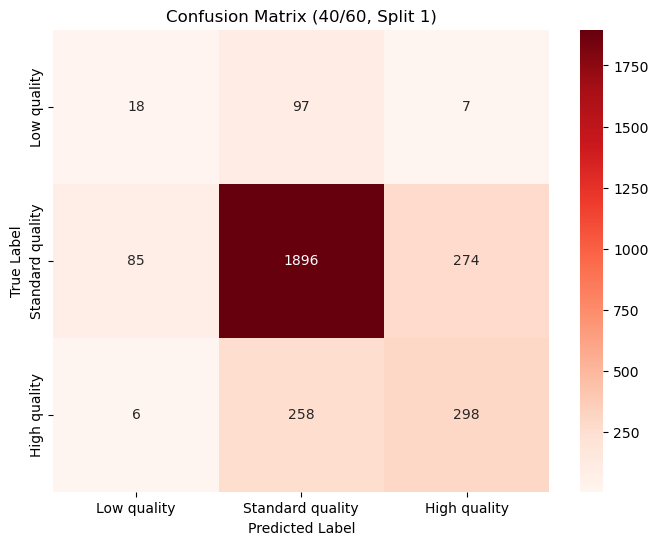


Train/Test Split: 60/40, Lần chia thứ 1
Classification Report:
                  precision    recall  f1-score   support

     Low quality       0.23      0.28      0.25        82
Standard quality       0.85      0.84      0.85      1504
    High quality       0.56      0.56      0.56       374

        accuracy                           0.77      1960
       macro avg       0.55      0.56      0.55      1960
    weighted avg       0.77      0.77      0.77      1960



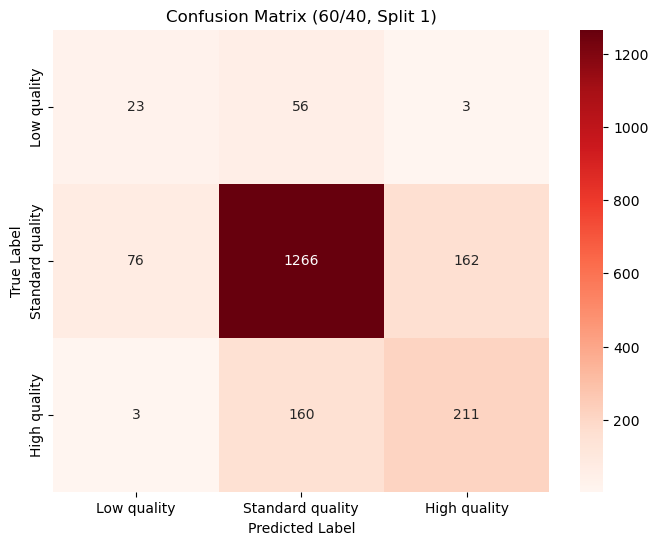


Train/Test Split: 80/20, Lần chia thứ 1
Classification Report:
                  precision    recall  f1-score   support

     Low quality       0.29      0.32      0.30        41
Standard quality       0.87      0.86      0.87       752
    High quality       0.60      0.61      0.61       187

        accuracy                           0.79       980
       macro avg       0.59      0.60      0.59       980
    weighted avg       0.80      0.79      0.79       980



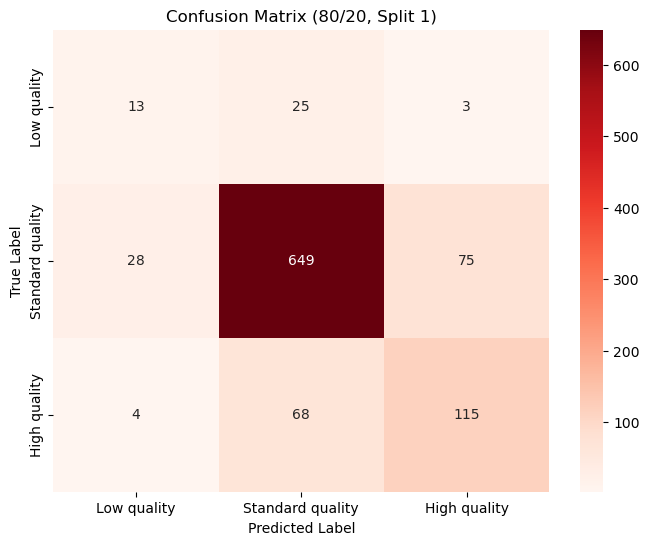


Train/Test Split: 90/10, Lần chia thứ 1
Classification Report:
                  precision    recall  f1-score   support

     Low quality       0.29      0.25      0.27        20
Standard quality       0.85      0.88      0.87       376
    High quality       0.61      0.54      0.57        94

        accuracy                           0.79       490
       macro avg       0.58      0.56      0.57       490
    weighted avg       0.78      0.79      0.79       490



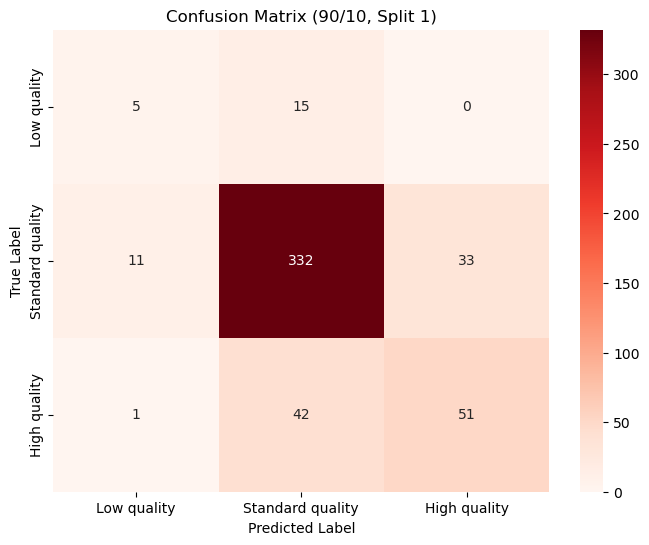

In [11]:
for (train_size, test_size, i), result in results.items():
    clf = result["model"]
    y_test = result["y_test"]
    y_pred = result["y_pred"]
    report = classification_report(y_test, y_pred, target_names=["Low quality", "Standard quality", "High quality"])
    cm = confusion_matrix(y_test, y_pred)    
    print(f"\nTrain/Test Split: {int(train_size*100)}/{int(test_size*100)}, Lần chia thứ {i+1}")
    print("Classification Report:")
    print(report)
    
    # Vẽ ma trận 
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=["Low quality", "Standard quality", "High quality"], yticklabels=["Low quality", "Standard quality", "High quality"])
    plt.title(f"Confusion Matrix ({int(train_size*100)}/{int(test_size*100)}, Split {i+1})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

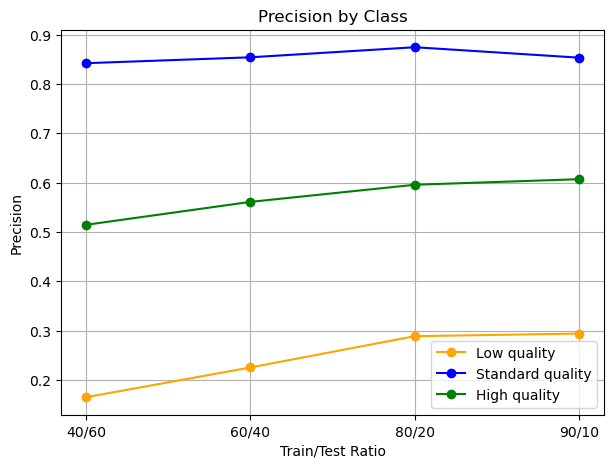

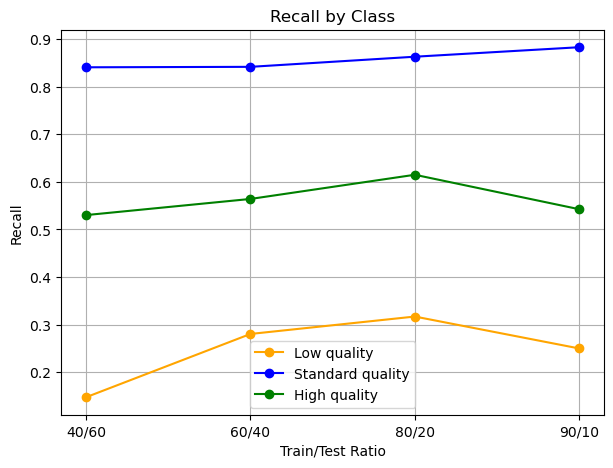

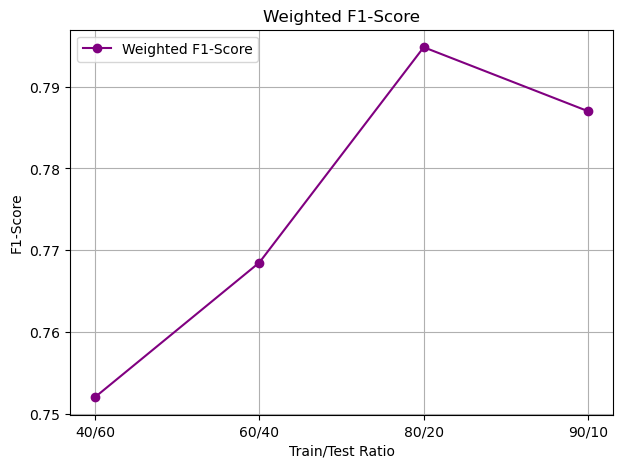

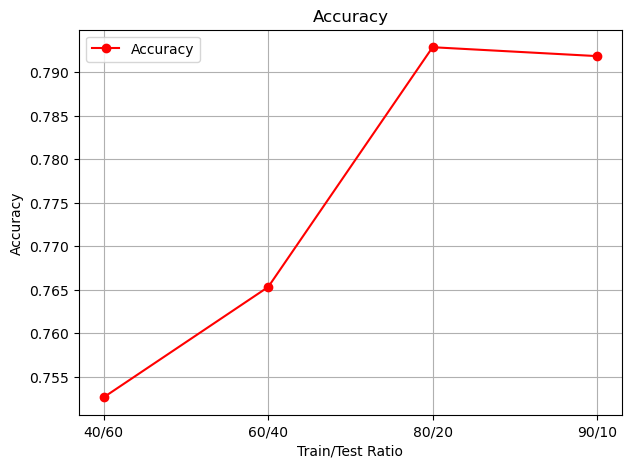

Final Metrics Summary:
Train/Test Ratio: 40/60
  Precision: Low=0.1651, Standard=0.8423, High=0.5147
  Recall: Low=0.1475, Standard=0.8408, High=0.5302
  Weighted F1-Score: 0.7520
  Accuracy: 0.7526

Train/Test Ratio: 60/40
  Precision: Low=0.2255, Standard=0.8543, High=0.5612
  Recall: Low=0.2805, Standard=0.8418, High=0.5642
  Weighted F1-Score: 0.7685
  Accuracy: 0.7653

Train/Test Ratio: 80/20
  Precision: Low=0.2889, Standard=0.8747, High=0.5959
  Recall: Low=0.3171, Standard=0.8630, High=0.6150
  Weighted F1-Score: 0.7948
  Accuracy: 0.7929

Train/Test Ratio: 90/10
  Precision: Low=0.2941, Standard=0.8535, High=0.6071
  Recall: Low=0.2500, Standard=0.8830, High=0.5426
  Weighted F1-Score: 0.7870
  Accuracy: 0.7918



In [12]:
# Vẽ các biểu đồ Precision, Recall, F1-Score, Accuracy
def plot_metrics_line(results):
    train_test_ratios = []
    precision_class0 = []  # Low quality
    precision_class1 = []  # Standard quality
    precision_class2 = []  # High quality
    recall_class0 = []
    recall_class1 = []
    recall_class2 = []
    weighted_f1_scores = []
    accuracies = []

    for (train_size, test_size, i), result in results.items():
        clf = result["model"]
        y_test = result["y_test"]
        y_pred = result["y_pred"]

        report = classification_report(y_test, y_pred, target_names=["Low quality", "Standard quality", "High quality"], output_dict=True)
        train_test_ratios.append(f"{int(train_size * 100)}/{int(test_size * 100)}")

        precision_class0.append(report["Low quality"]["precision"])
        precision_class1.append(report["Standard quality"]["precision"])
        precision_class2.append(report["High quality"]["precision"])

        recall_class0.append(report["Low quality"]["recall"])
        recall_class1.append(report["Standard quality"]["recall"])
        recall_class2.append(report["High quality"]["recall"])

        weighted_f1_scores.append(report["weighted avg"]["f1-score"])
        accuracies.append(accuracy_score(y_test, y_pred))

    # Vẽ biểu đồ Precision 
    plt.figure(figsize=(7, 5))
    plt.plot(train_test_ratios, precision_class0, marker='o', linestyle='-', color='orange', label='Low quality')
    plt.plot(train_test_ratios, precision_class1, marker='o', linestyle='-', color='blue', label='Standard quality')
    plt.plot(train_test_ratios, precision_class2, marker='o', linestyle='-', color='green', label='High quality')
    plt.title("Precision by Class")
    plt.xlabel("Train/Test Ratio")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Vẽ biểu đồ Recall 
    plt.figure(figsize=(7, 5))
    plt.plot(train_test_ratios, recall_class0, marker='o', linestyle='-', color='orange', label='Low quality')
    plt.plot(train_test_ratios, recall_class1, marker='o', linestyle='-', color='blue', label='Standard quality')
    plt.plot(train_test_ratios, recall_class2, marker='o', linestyle='-', color='green', label='High quality')
    plt.title("Recall by Class")
    plt.xlabel("Train/Test Ratio")
    plt.ylabel("Recall")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Vẽ biểu đồ Weighted F1-Score
    plt.figure(figsize=(7, 5))
    plt.plot(train_test_ratios, weighted_f1_scores, marker='o', linestyle='-', color='purple', label='Weighted F1-Score')
    plt.title("Weighted F1-Score")
    plt.xlabel("Train/Test Ratio")
    plt.ylabel("F1-Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Vẽ biểu đồ Accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(train_test_ratios, accuracies, marker='o', linestyle='-', color='red', label='Accuracy')
    plt.title("Accuracy")
    plt.xlabel("Train/Test Ratio")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Final Metrics Summary:")
    for ratio, precision0, precision1, precision2, recall0, recall1, recall2, f1, acc in zip(
        train_test_ratios, precision_class0, precision_class1, precision_class2, recall_class0, recall_class1, recall_class2, weighted_f1_scores, accuracies
    ):
        print(f"Train/Test Ratio: {ratio}")
        print(f"  Precision: Low={precision0:.4f}, Standard={precision1:.4f}, High={precision2:.4f}")
        print(f"  Recall: Low={recall0:.4f}, Standard={recall1:.4f}, High={recall2:.4f}")
        print(f"  Weighted F1-Score: {f1:.4f}")
        print(f"  Accuracy: {acc:.4f}\n")
plot_metrics_line(results)

## 4. Độ sâu và độ chính xác của Decision Tree

In [13]:
save_folder = "./Image4Depths/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    
# Chia dữ liệu thành train/test với tỷ lệ 80/20
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

max_depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracy_results = []

for max_depth in max_depth_values:
    # Kiểm tra nếu max_depth là None, thì không giới hạn độ sâu
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)  
    accuracy_results.append(accuracy)
    
    if max_depth is None:
        file_name_png = os.path.join(save_folder, "decision_tree_max_depth_None")
    else:
        file_name_png = os.path.join(save_folder, f"decision_tree_max_depth_{max_depth}")
    
    # Tạo cây quyết định với Graphviz
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=X.columns,
        class_names=["Low quality", "Standard quality", "High quality"],
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    graph.render(filename=file_name_png, format='png', cleanup=True)
    
    print(f"Cây quyết định với max_depth={max_depth} đã được lưu vào {file_name_png}")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.736983 to fit


Cây quyết định với max_depth=None đã được lưu vào ./Image4Depths/decision_tree_max_depth_None
Cây quyết định với max_depth=2 đã được lưu vào ./Image4Depths/decision_tree_max_depth_2
Cây quyết định với max_depth=3 đã được lưu vào ./Image4Depths/decision_tree_max_depth_3
Cây quyết định với max_depth=4 đã được lưu vào ./Image4Depths/decision_tree_max_depth_4
Cây quyết định với max_depth=5 đã được lưu vào ./Image4Depths/decision_tree_max_depth_5
Cây quyết định với max_depth=6 đã được lưu vào ./Image4Depths/decision_tree_max_depth_6
Cây quyết định với max_depth=7 đã được lưu vào ./Image4Depths/decision_tree_max_depth_7


- Để chuyển đổi tệp .dot sang định dạng hình ảnh (PNG), cần sử dụng lệnh dot trong terminal: dot -Tpng decision_tree_max_depth_7.dot -o decision_tree_max_depth_7.png

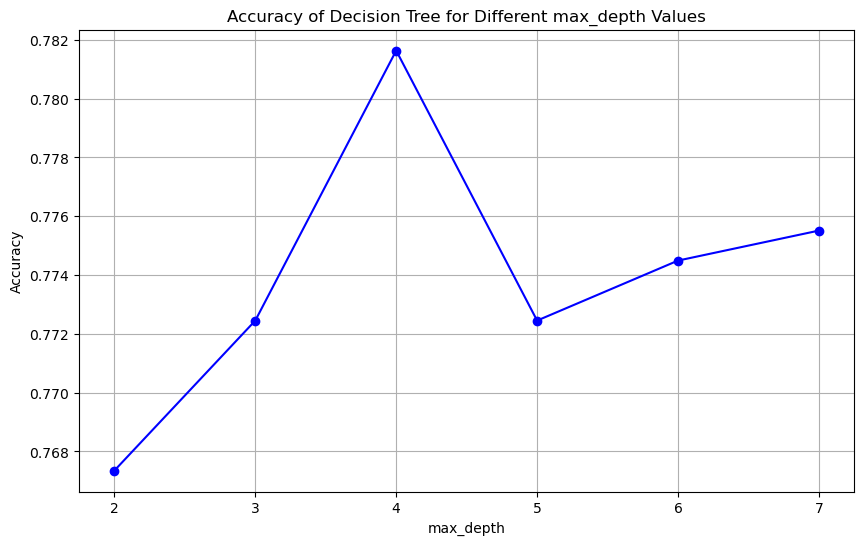


Độ chính xác của các mô hình Decision Tree với các giá trị max_depth:
max_depth=2: Accuracy=0.7673
max_depth=3: Accuracy=0.7724
max_depth=4: Accuracy=0.7816
max_depth=5: Accuracy=0.7724
max_depth=6: Accuracy=0.7745
max_depth=7: Accuracy=0.7755


In [14]:
# Loại bỏ None để vẽ biểu đồ
max_depth_values_no_none = [x for x in max_depth_values if x is not None]
accuracy_results_no_none = [accuracy_results[i] for i, val in enumerate(max_depth_values) if val is not None]

plt.figure(figsize=(10, 6))
plt.plot(max_depth_values_no_none, accuracy_results_no_none, marker='o', linestyle='-', color='b')
plt.title("Accuracy of Decision Tree for Different max_depth Values")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.xticks(max_depth_values_no_none)  # Sử dụng các giá trị max_depth không phải None
plt.grid(True)
plt.show()
print("\nĐộ chính xác của các mô hình Decision Tree với các giá trị max_depth:")
for max_depth, accuracy in zip(max_depth_values_no_none, accuracy_results_no_none):
    print(f"max_depth={max_depth}: Accuracy={accuracy:.4f}")